In [443]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [444]:
import xgboost
xgboost.__version__

'1.7.1'

In [446]:
med = pd.read_csv('pharmacy_tx.csv')

In [453]:
med['Acceptance'] = 0
med.dropna(inplace=True)
med.loc[med['rejected']==False,'Acceptance'] = 1
med['tx_date'] = pd.to_datetime(med['tx_date'])
med['days'] = med['tx_date'] - pd.to_datetime('2022-01-01')
med['days'] = med['days']/np.timedelta64(1,'D')
med[['drug_type','drug_name']] = med['drug'].str.split(expand=True)
features = ['drug_type','drug_name','diagnosis','pharmacy','pcn','group','bin']
med[features] = med[features].astype('category')

In [456]:
med.sample(10)

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,Acceptance,days,drug_type,drug_name
4455528,2022-05-09,Pharmacy #55,I68.27,generic prazinib,718350,J5DT8,IX6P0,False,10.59,1,128.0,generic,prazinib
4738617,2022-05-15,Pharmacy #44,G99.93,branded bovirol,718350,J5DT8,IX6P0,False,12.74,1,134.0,branded,bovirol
6696553,2022-07-07,Pharmacy #27,I68.27,branded mule,664344,REGLCC,BH2Q8B3GY2GAV,False,53.09,1,187.0,branded,mule
221758,2022-01-09,Pharmacy #31,P07.55,generic colade,691847,N098KI,6SP1DG,False,15.55,1,8.0,generic,colade
3372880,2022-04-09,Pharmacy #7,H33.06,generic tovane,691847,N098KI,6SP1DG,False,15.55,1,98.0,generic,tovane
4342818,2022-05-06,Pharmacy #7,I68.27,branded prazinib,691847,N098KI,6SP1DG,False,15.55,1,125.0,branded,prazinib
10989103,2022-10-19,Pharmacy #51,H36.57,branded antimab,691847,N098KI,6SP1DG,False,17.93,1,291.0,branded,antimab
12886085,2022-12-05,Pharmacy #7,U60.52,branded oxasoted,725700,327CKV,IOEAN1DWVV3Y,False,11.15,1,338.0,branded,oxasoted
3727053,2022-04-17,Pharmacy #41,H11.36,branded prazinib,322463,9FU70,U19J4RVCA,False,13.80,1,106.0,branded,prazinib
75151,2022-01-05,Pharmacy #15,Y11.84,branded tovane,725700,327CKV,IOEAN1DWVV3Y,False,12.03,1,4.0,branded,tovane


In [457]:
med.info() # check if data type changed to category

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6412338 entries, 3 to 13910241
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tx_date      datetime64[ns]
 1   pharmacy     category      
 2   diagnosis    category      
 3   drug         object        
 4   bin          category      
 5   pcn          category      
 6   group        category      
 7   rejected     bool          
 8   patient_pay  float64       
 9   Acceptance   int64         
 10  days         float64       
 11  drug_type    category      
 12  drug_name    category      
dtypes: bool(1), category(7), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 348.6+ MB


In [460]:
columns = ['drug_type','drug_name','diagnosis','pharmacy','bin','pcn','group','days','Acceptance','patient_pay']
selected_data = med[columns].copy()

In [461]:
selected_data.sample(10) # select a portion of features that we're interested

,drug_type,drug_name,diagnosis,pharmacy,bin,pcn,group,days,Acceptance,patient_pay
3460967,branded,tovane,U27.71,Pharmacy #41,571569,KB38N,6BYJBW,100.0,1,13.99
7476628,generic,gorol,G99.93,Pharmacy #33,322463,T52GV,EVD4X5,204.0,1,5.19
570348,generic,keglusited,U60.52,Pharmacy #8,664344,IF448,FZPLF4O6FD,17.0,1,19.82
8286288,branded,momudobatin,Q72.66,Pharmacy #25,956971,WM6A,L9QZA,226.0,1,65.18
7383519,branded,pucomalol,K32.86,Pharmacy #32,664344,TAZ5W,T51T6V2E8L,202.0,1,17.68
12308239,generic,prazinib,G51.87,Pharmacy #1,725700,327CKV,IOEAN1DWVV3Y,322.0,1,10.62
10294706,generic,colade,P07.55,Pharmacy #38,691847,N098KI,6SP1DG,276.0,1,15.55
3964339,branded,nicotilin,M06.85,Pharmacy #13,664344,REGLCC,BH2Q8B3GY2GAV,112.0,0,0.00
7873605,branded,hidizuzunib,I68.27,Pharmacy #18,725700,327CKV,IOEAN1DWVV3Y,217.0,1,93.28
8000620,generic,foxivelule,U27.71,Pharmacy #2,956971,WM6A,L9QZA,219.0,1,10.00


In [462]:
features = ['drug_type','drug_name','diagnosis','pharmacy','bin','pcn','group','days']
from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(selected_data[features], selected_data['Acceptance'], test_size=test_size, random_state=seed, stratify=selected_data['Acceptance'], shuffle=True)

In [463]:
# check if the split data set cary the same portion of rejection categories
print(sum(y_train==1)/len(y_train))
print(sum(y_train==0)/len(y_train))
print(sum(y_test==1)/len(y_test))
print(sum(y_test==0)/len(y_test))

0.9228951220986107
0.07710487790138931
0.9228947622864664
0.07710523771353359


# XGBoost classification model
### Predict whether accepted or rejected by the insurance company

In [464]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method="hist",enable_categorical=True)
xgb.fit(X_train,y_train)
# feature importance
print(xgb.feature_importances_)

[0.39517245 0.47999212 0.01211273 0.00572709 0.05274609 0.04873854
 0.00324638 0.00226458]


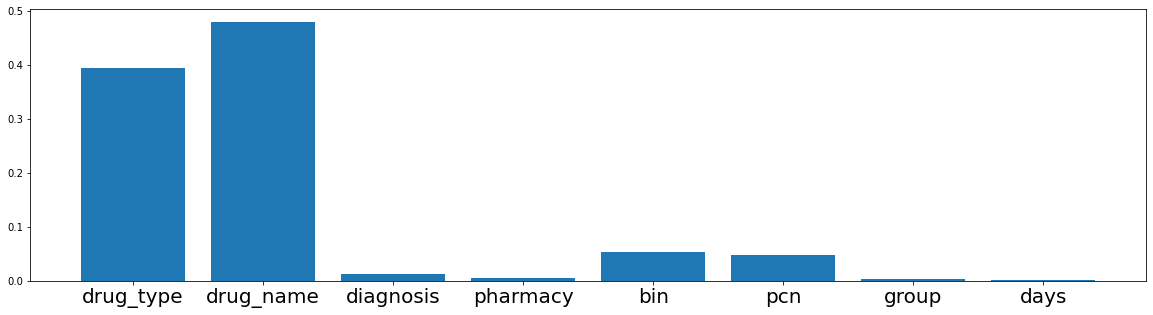

In [465]:
# plot feature importance
plt.figure(figsize=(20,5))
plt.bar(features, xgb.feature_importances_)
plt.xticks(fontsize=20)
plt.show()

In [466]:
k = 5
mean_accuracy = np.zeros((k,1))
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
j = 0
kfold = StratifiedKFold(k, shuffle=True)
accuracy = np.zeros((k,1))
TPR = np.zeros((k,1))
Precision = np.zeros((k,1))
FPR = np.zeros((k,1))
FNR = np.zeros((k,1))
FDR = np.zeros((k,1))
TNR = np.zeros((k,1))
for train_idx, test_idx in kfold.split(X_train,y_train):
    X_t = X_train.iloc[train_idx]
    X_h = X_train.iloc[test_idx]
    y_t = y_train.iloc[train_idx]
    y_h = y_train.iloc[test_idx]
    xgb.fit(X_t,y_t)
    pred = xgb.predict(X_h)
    accuracy[j] = accuracy_score(y_h,pred)
    confusion_m = confusion_matrix(y_h,pred)
    FP = confusion_m[0,1]
    FN = confusion_m[1,0]
    TP = confusion_m[0,0]
    TN = confusion_m[1,1]
    # Sensitivity, recall, or true positive rate
    TPR[j] = TP/(TP+FN)
    # Specificity or true negative rate
    TNR[j] = TN/(TN+FP) 
    # Precision
    Precision[j] = TP/(TP+FP)
    # False positive rate
    FPR[j] = FP/(FP+TN)
    # False negative rate
    FNR[j] = FN/(TP+FN)
    # False discovery rate
    FDR[j] = FP/(TP+FP)
    j += 1
print('Accuracy score : {}'.format(np.mean(accuracy)))
print('Sensitivity : {}'.format(np.mean(TPR)))
print('Specificity : {}'.format(np.mean(TNR)))
print('Precision : {}'.format(np.mean(Precision)))
print('False positive rate : {}'.format(np.mean(FPR)))
print('False negative rate : {}'.format(np.mean(FNR)))
print('False discovery rate : {}'.format(np.mean(FDR)))

Accuracy score : 0.9228307929830579
Sensitivity : 0.3398351617897677
Specificity : 0.9229478790697019
Precision : 0.000884870637183521
False positive rate : 0.07705212093029801
False negative rate : 0.6601648382102322
False discovery rate : 0.9991151293628165


In [467]:
# Perform analysis on the whole data set
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
confusion_m = confusion_matrix(y_test,pred)
accuracyscore = accuracy_score(y_test,pred)
FP = confusion_m[0,1]
FN = confusion_m[1,0]
TP = confusion_m[0,0]
TN = confusion_m[1,1]
# Sensitivity, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision
Precision = TP/(TP+FP)
# False positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print('Accuracy score : {}'.format(accuracyscore))
print('Sensitivity : {}'.format(TPR))
print('Specificity : {}'.format(TNR))
print('Precision : {}'.format(Precision))
print('False positive rate : {}'.format(FPR))
print('False negative rate : {}'.format(FNR))
print('False discovery rate : {}'.format(FDR))

Accuracy score : 0.9228596736916632
Sensitivity : 0.3282442748091603
Specificity : 0.9229204179556544
Precision : 0.0004348485614602821
False positive rate : 0.07707958204434559
False negative rate : 0.6717557251908397
False discovery rate : 0.9995651514385397


# Regression with label encoding or one-hot encoding
### Predict payment by the patients

In [468]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
selected_data_2 = selected_data.loc[selected_data['Acceptance']==1]
for f in features:
    if f != 'days':
        selected_data_2[f] = label_encoder.fit_transform(selected_data_2[f])

<ipython-input-468-c4eabe7a82d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data_2[f] = label_encoder.fit_transform(selected_data_2[f])


In [469]:
selected_data_2

,drug_type,drug_name,diagnosis,pharmacy,bin,pcn,group,days,Acceptance,patient_pay
3,1,48,99,24,4,13,2,1.0,1,10.84
6,0,19,99,11,8,1,15,1.0,1,11.15
13,0,4,55,18,9,15,8,1.0,1,17.56
18,1,67,36,18,8,1,15,1.0,1,6.50
21,1,52,33,15,6,33,17,1.0,1,10.72
...,...,...,...,...,...,...,...,...,...,...
13910233,1,57,36,4,1,21,23,363.0,1,5.32
13910235,0,57,86,6,9,15,8,363.0,1,17.56
13910236,1,52,51,26,9,23,25,363.0,1,10.72
13910238,0,40,83,33,4,13,2,363.0,1,66.47


In [470]:
seed = 42
test_size = 0.2
X2_train, X2_test, y2_train, y2_test = train_test_split(selected_data_2[features], selected_data_2['patient_pay'], test_size=test_size, random_state=seed, shuffle=True)

In [471]:
from xgboost import XGBRegressor
def plot_feature_importances(reg,X,y):
    reg.fit(X, y)
    print(reg.feature_importances_)
    plt.figure(figsize=(20,5))
    plt.bar(features, reg.feature_importances_)
    plt.xticks(fontsize=20)
    plt.show()

In [472]:
from sklearn.model_selection import KFold
def XGBRegressor_label_encoding(reg,X_train,y_train):
    k = 5
    kfold = KFold(k, shuffle=True)
    mean_accuracy = np.zeros((k,1))
    mean_sq_error = np.zeros((k,1))
    TPR = np.zeros((k,1))
    Precision = np.zeros((k,1))
    FPR = np.zeros((k,1))
    FNR = np.zeros((k,1))
    FDR = np.zeros((k,1))
    TNR = np.zeros((k,1))
    j = 0
    for train_idx, test_idx in kfold.split(X_train,y_train):
        X_t = X2_train.iloc[train_idx]
        X_h = X2_train.iloc[test_idx]
        y_t = y2_train.iloc[train_idx]
        y_h = y2_train.iloc[test_idx]
        reg.fit(X_t,y_t)
        pred = reg.predict(X_h)
        mean_sq_error[j] = mean_squared_error(y_h,pred)
        j += 1
    print('mean_squared_error : {}'.format(np.mean(mean_sq_error)))

### Label encoding

[0.19772741 0.20329858 0.43499637 0.00064194 0.06816942 0.04289741
 0.04974939 0.0025194 ]


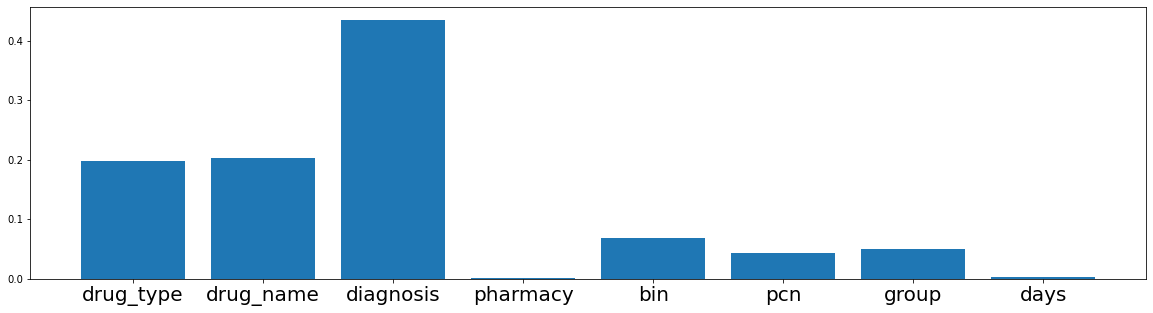

mean_squared_error : 40.848315739054435


In [473]:
reg = XGBRegressor(tree_method="hist")
plot_feature_importances(reg,X2_train,y2_train)
XGBRegressor_label_encoding(reg,X2_train,y2_train)

### One-hot encoding

[1.7112949e-01 4.0191013e-01 3.4667790e-01 4.7738366e-05 3.3081133e-02
 4.6695139e-02 0.0000000e+00 4.5852497e-04]


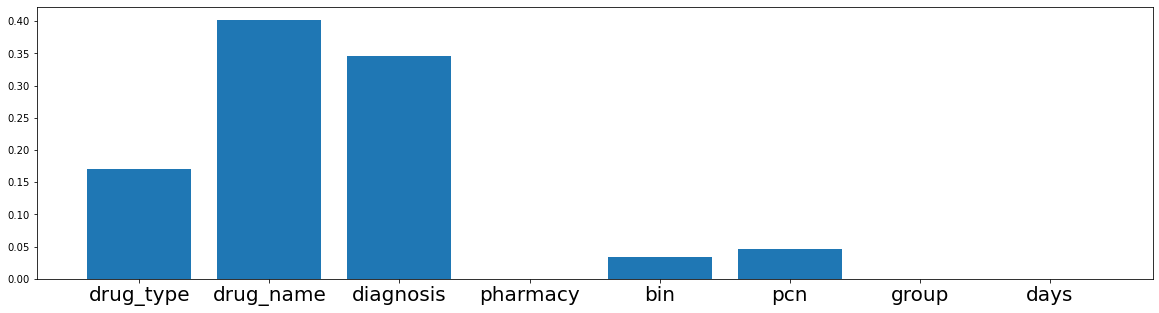

mean_squared_error : 41.885947617858506


In [474]:
selected_data_3 = selected_data.loc[selected_data['Acceptance']==1]
X3_train, X3_test, y3_train, y3_test = train_test_split(selected_data_3[features], selected_data_3['patient_pay'], test_size=test_size, random_state=seed, shuffle=True)
reg = XGBRegressor(tree_method="hist", enable_categorical=True, max_cat_to_onehot=100000)
plot_feature_importances(reg,X3_train,y3_train)
XGBRegressor_label_encoding(reg,X3_train,y3_train)